In [1]:
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler, LabelEncoder
from itertools import cycle, islice

import networkx as nx
from scipy import sparse
from sklearn.cluster import KMeans

np.random.seed(0)


In [2]:
def get_cluster_centroids(X, y):
    """获取聚类中心"""
    df=pd.DataFrame(X)
    cols = df.columns
    df['y'] = y
    return df.groupby('y')[cols].mean().values

In [3]:
def spectral_clustering(X, n_eigvec , k_neighbors, type='unnormalized'):
    """
    Inputs: 
    X - Array of data points
    k - Number of clusters to construct
    params - Additional parameters for constructing the similarity graph
    """
    n = len(X)
    
    # 计算相似图(邻接矩阵)，计算前k个邻居的加权图，采用欧式距离
    A = kneighbors_graph(X, k_neighbors, mode='distance', metric='euclidean', include_self=True)
    
    # Compute the unnormalized Laplacian L
    G = nx.from_scipy_sparse_matrix(A)
    L = nx.laplacian_matrix(G)
    D = None
    if type=='random_walk':
        D= G.degree(G.nodes(), weight='weight')
        D = np.array(D)[:,1]
        D = sparse.diags(D)
    elif type=='symmetric':
        L= nx.normalized_laplacian_matrix(G)
            
    #找到矩阵L的k个特征向量
    eigenvalues, eigenvectors = sparse.linalg.eigs(L, k=n_eigvec, M=D, which='SM')
    eigenvectors = np.real_if_close(eigenvectors)
    eigenvalues = np.real_if_close(eigenvalues)
    kfirst_indices = np.argsort(eigenvalues)[:n_eigvec] # 特征值排序索引      
    vector = eigenvectors[:,kfirst_indices] # 按特征值大小索引对特征向量排序，每一列是一个特征向量    
   
    kmeans = KMeans(n_clusters=n_eigvec, random_state=0).fit(vector.astype(float)) # 对特征向量进行聚类   
   
    return {
        'labels': kmeans.labels_,
        'centroids': get_cluster_centroids(X,kmeans.labels_)
    }

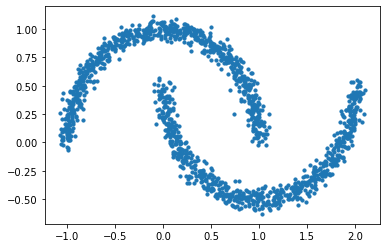

In [4]:
# 创建数据集
X, y = datasets.make_moons(n_samples=1500, noise=.05)
plt.scatter(X[:,0], X[:,1], s=10)

In [5]:
kmeans = cluster.KMeans(n_clusters=2)
pred_kmeans = kmeans.fit(X).labels_.astype(np.int)
pred_unnormalized = spectral_clustering(X, 2 , 12, type='unnormalized')['labels']
pred_random_walk = spectral_clustering(X, 2 , 12, type='random_walk')['labels']
pred_normalized = spectral_clustering(X, 2 , 12, type='symmetric')['labels'] 

C:\Users\Administrator\AppData\Local\Temp\ipykernel_15792\2594441774.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_kmeans = kmeans.fit(X).labels_.astype(np.int)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_15792\4058912604.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
  kmeans = KMeans(n_clusters=n_eigvec, random_state=0).fit(vector.astype(float)) # 对特征向量进行聚类


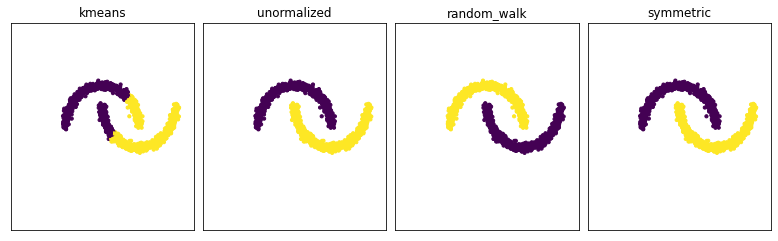

In [6]:
plt.figure(figsize=(4 * 2 + 3, 3))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,hspace=.01)
titles = ['kmeans', 'unormalized', 'random_walk', 'symmetric']
for i, y_pred in enumerate([pred_kmeans,pred_unnormalized ,pred_random_walk, pred_normalized]):
    plt.subplot(1, 4, i+1)
    plt.title(titles[i])
    plt.scatter(X[:, 0], X[:, 1], s=10, c=y_pred)
    plt.xlim(-2.5, 2.5)
    plt.ylim(-2.5, 2.5)
    plt.xticks(())
    plt.yticks(())